In [2]:
import datacube
import sys
import xarray as xr
import pandas as pd
import numpy as np
from datacube.storage import masking
from skimage import exposure
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import display_map
from dea_dask import create_local_dask_cluster


# Create local dask cluster to improve data load time
create_local_dask_cluster()


from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import unsharp_mask

def hsv_image_processing(rgb_array,
                         hue_mult=1, 
                         sat_mult=1, 
                         val_mult=1,
                         unsharp_radius=10, 
                         unsharp_amount=1):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Apply unsharp mask to value band only
    hsv_array[:, :, 2] = unsharp_mask(image=hsv_array[:, :, 2], 
                                      radius=unsharp_radius, 
                                      amount=unsharp_amount)
    
    # Convert back to RGB
    return hsv2rgb(hsv_array)


/env/lib/python3.6/site-packages/datacube/storage/masking.py:8: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Client Scheduler: tcp://127.0.0.1:45605 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


In [5]:
import numpy as np
import datacube
from datacube.api.query import query_group_by
from datacube.model.utils import xr_apply
dc = datacube.Datacube(app='Metadata')

# # Spatiotemporal query
# query = dict(product='ga_ls8c_ard_3', 
#              lat=(-35.0, -36), 
#              lon=(148.0, 149), 
#              time='2018', 
#              group_by='solar_day'
#             )

# # Load the metadata from each dataset into 
# # an xarray after grouping by solar day
# gb = query_group_by(**query)
# datasets = dc.find_datasets(**query)
# dataset_array = dc.group_datasets(datasets, gb)
# cloud_cover = xr_apply(dataset_array, lambda t, dd: [d.metadata.platform for d in dd][0])

# # Load the satellite data data
# ds = dc.load(datasets=datasets, 
#              measurements=['nbart_red'],
#              output_crs='EPSG:3577', 
#              resolution=(-30, 30), 
#              dask_chunks={},
#              group_by='solar_day',
#             )

# # Add metadata to data
# ds['cloud_cover'] = cloud_cover
# ds

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [13]:
import datacube
dc = datacube.Datacube(app='')

ds = dc.load(product='ga_ls8c_ard_3', 
             measurements=['nbart_red'],
             y=(-35.0, -36), 
             x=(148.0, 149), 
             time='2018', 
             group_by='solar_day',
             output_crs='EPSG:3577', 
             resolution=(-30, 30), 
             dask_chunks={},
            )
ds

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


<xarray.Dataset>
Dimensions:      (time: 46, x: 3473, y: 4062)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:56:37.516439 ... 2018-12...
  * y            (y) float64 -3.913e+06 -3.913e+06 ... -4.035e+06 -4.035e+06
  * x            (x) float64 1.439e+06 1.439e+06 ... 1.543e+06 1.543e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) int16 dask.array<chunksize=(1, 4062, 3473), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


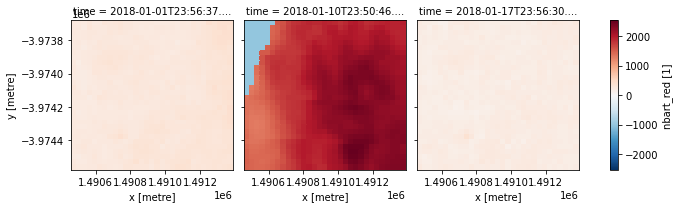

In [61]:
import datacube
dc = datacube.Datacube(app='')

# Set coordinate
y, x = -3974130, 1490925
buffer = 5  # pixels to buffer

# Load data
load_buffer = (buffer + 10) * 30 
ds = dc.load(product='ga_ls8c_ard_3', 
             measurements=['nbart_red'],
             y=(y - load_buffer, y + load_buffer), 
             x=(x - load_buffer, x + load_buffer), 
             time='2018-01', 
             crs='EPSG:3577',
             output_crs='EPSG:3577', 
             resolution=(-30, 30), 
             group_by='solar_day',
            )
ds.nbart_red.plot(col='time')

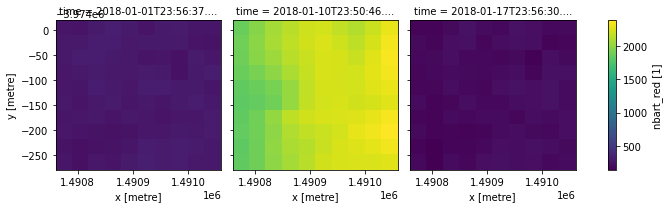

In [62]:
# Convert coordinate to row/col
col, row = ~ds.geobox.transform * (x, y)

# Extract with buffer around row/col (untested, may be off by one!)
ds.isel(x=slice(int(row) - buffer, int(row) + buffer),
        y=slice(int(col) - buffer, int(col) + buffer)).nbart_red.plot(col='time')

In [56]:
ds.isel(x=slice(int(row) - buffer, int(row) + buffer),
        y=slice(int(col) - buffer, int(col) + buffer))

<xarray.Dataset>
Dimensions:      (time: 3, x: 10, y: 10)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:56:37.516439 ... 2018-01...
  * y            (y) float64 -3.974e+06 -3.974e+06 ... -3.974e+06 -3.974e+06
  * x            (x) float64 1.491e+06 1.491e+06 ... 1.491e+06 1.491e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) int16 265 255 290 325 294 ... 233 213 226 188 204
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [45]:
col, row = ~ds.geobox.transform * (xx, yy)
buffer = 5
ds.nbart_red[:, int(row) - buffer:int(row) + buffer, int(col) - buffer:int(col) + buffer]

<xarray.DataArray 'nbart_red' (time: 46, y: 10, x: 10)>
dask.array<getitem, shape=(46, 10, 10), dtype=int16, chunksize=(1, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:56:37.516439 ... 2018-12...
  * y            (y) float64 -3.974e+06 -3.974e+06 ... -3.974e+06 -3.974e+06
  * x            (x) float64 1.491e+06 1.491e+06 ... 1.491e+06 1.491e+06
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        -999
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [44]:
ds.nbart_red[:, int(row) - 5:int(row) + 5, int(col) - 5:int(col) + 5]

<xarray.DataArray 'nbart_red' (time: 46, y: 10, x: 10)>
dask.array<getitem, shape=(46, 10, 10), dtype=int16, chunksize=(1, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:56:37.516439 ... 2018-12...
  * y            (y) float64 -3.974e+06 -3.974e+06 ... -3.974e+06 -3.974e+06
  * x            (x) float64 1.491e+06 1.491e+06 ... 1.491e+06 1.491e+06
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        -999
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [4]:
# Load the satellite data data
ds = dc.load(datasets=datasets, 
             output_crs='EPSG:3577', 
             resolution=(-30, 30), 
             dask_chunks={},
            )

ds

<xarray.Dataset>
Dimensions:                     (time: 23, x: 8424, y: 8398)
Coordinates:
  * time                        (time) datetime64[ns] 2018-01-01T23:56:37.516...
  * y                           (y) float64 -3.748e+06 -3.748e+06 ... -4e+06
  * x                           (x) float64 1.359e+06 1.359e+06 ... 1.612e+06
    spatial_ref                 int32 3577
Data variables:
    nbart_coastal_aerosol       (time, y, x) int16 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    nbart_blue                  (time, y, x) int16 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    nbart_green                 (time, y, x) int16 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    nbart_red                   (time, y, x) int16 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    nbart_nir                   (time, y, x) int16 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    nbart_swir_1                (time, y, x) int16 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    nbart_swir_2                (time, y, x) int16 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    nbart_panchromatic          (time, y, x) int16 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_fmask                    (time, y, x) uint8 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_nbart_contiguity         (time, y, x) uint8 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_azimuthal_exiting        (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_azimuthal_incident       (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_combined_terrain_shadow  (time, y, x) uint8 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_exiting_angle            (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_incident_angle           (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_relative_azimuth         (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_relative_slope           (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_satellite_azimuth        (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_satellite_view           (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_solar_azimuth            (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_solar_zenith             (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
    oa_time_delta               (time, y, x) float32 dask.array<chunksize=(1, 8398, 8424), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
# # East coast fires, tall
# upper_left = -27.7500, 152.0000
# lower_right = -30.8000, 155.2000
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# resolution = (-50, 50)
# output_crs='EPSG:32756'
# percentile_stretch = (3, 97)
# log_transform = True

# # East coast fires, zoom Clarence
# upper_left = -29.380, 153.0776
# lower_right = -29.6510, 153.5308
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2a_nrt_granule'
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32756'
# percentile_stretch = (1, 99)
# log_transform = False

# # East coast fires, zoom
# upper_left = -30.0000, 152.2360
# lower_right = -30.1800, 152.4000
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2a_nrt_granule'
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# log_transform = False

# # East coast fires, Byfield
# upper_left = -21.4227, 149.7546
# lower_right = -23.000, 151.1000
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2b_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-40, 40)
# output_crs='EPSG:32755'
# percentile_stretch = (2, 99.99)
# log_transform = True

# # East coast fires, Byfield zoom
# upper_left =  -22.4550, 150.520
# lower_right = -22.7350, 150.820
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2b_nrt_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32755'
# percentile_stretch = (1, 99)
# power = 0.8

# # East coast fires, zoom 14 Sep
# upper_left = -30.01, 152.30158
# lower_right = -30.15, 152.47084
# time_range = ('2019-09-13', '2019-09-15')
# product = 's2b_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32755'
# percentile_stretch = (1, 99)
# power = 0.3

# # NBART comparison
# upper_left = -37.07900, 145.07884
# lower_right = -37.21756, 145.27370
# time_range = ('2016-04-26', '2016-04-26')
# product = 's2a_ard_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32755'
# percentile_stretch = (0.5, 99.5)
# power = None

# # Forster fires, 2019
# upper_left = -29.1072, 151.3758
# lower_right = -29.365, 151.8352
# time_range = ('2019-11-11', '2019-11-11')
# product = 's2a_nrt_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32756'
# percentile_stretch = (5, 98.4)
# power = None

# # Canberra fire
# upper_left = -35.4597, 148.7372
# lower_right = -35.9473, 149.1809
# time_range = ('2020-02-03', '2020-02-05')
# product = 's2b_nrt_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_swir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (0.2, 99.8)
# power = 0.5


# # Colour test
# upper_left = -28.47902, 153.12817
# lower_right = -28.88231, 153.65592
# time_range = ('2020-01-20', '2020-01-24')
# product = 's2b_nrt_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbart_swir_3', 'nbart_nir_2', 'nbart_red']
# resolution = (-50, 50)
# output_crs='EPSG:32756'
# percentile_stretch = (2, 98.4)
# power = None


# # Botany Bay
# upper_left =  -33.9342, 151.1111
# lower_right = -34.0595, 151.2935
# time_range = ('2020-02-10', '2020-02-12')
# product = 's2b_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbart_swir_3', 'nbart_nir_2', 'nbart_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (1, 99)
# power = 0.5

# # Waragamba Dam
# upper_left = -34.08, 150.30413
# lower_right = -34.18823, 150.40936
# time_range = ('2020-02-19', '2020-02-19')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbart_swir_3', 'nbart_nir_2', 'nbart_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# power = 1

# # Lake Carnagie
# upper_left =  -25.9245, 122.0678
# lower_right = -26.3399, 122.7669
# time_range = ('2020-02-15', '2020-02-19')
# product = 's2a_ard_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# resolution = (-10, 10)
# output_crs='EPSG:32751'
# percentile_stretch = (0.05, 99.65)
# power = 0.6


# # Tasmania fires, 2016
# upper_left = -41.22, 144.74
# lower_right = -41.45, 145.26
# time_range = ('2016-03-14', '2016-03-14')
# product = 's2a_ard_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32755'
# percentile_stretch = (0.5, 99.5)
# power = 0.8


# upper_left = -19.80, 119.0
# lower_right = -20.05, 119.5
# time_range = ('2018-09-02', '2018-09-06')
# product = 's2b_ard_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32750'
# percentile_stretch = (0.5, 99.5)
# power = 0.8


# # Algae - Burley-Griffin
# upper_left = -35.274, 149.0926
# lower_right = -35.320, 149.1626
# time_range = ('2021-03-05', '2021-03-05')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-5, 5)
# output_crs='EPSG:32756'
# percentile_stretch = (1, 99)
# power = 0.5

# # Algae - Burundjuck
# upper_left = -34.953, 148.57841
# lower_right = -35.05, 148.722
# time_range = ('2021-03-05', '2021-03-05')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-5, 5)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# power = 0.9

# upper_left =  -34.9013, 148.687
# lower_right = -34.9801, 148.827
# time_range = ('2021-03-05', '2021-03-05')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-5, 5)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# power = 0.7




# upper_left =  -33.52938, 150.67097
# lower_right = -33.70692, 150.93533
# time_range = ('2021-03-25', '2021-03-27')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# power = 0.7

# upper_left =  -33.52938, 150.67097
# lower_right = -33.70692, 150.93533
# time_range = ('2021-03-14', '2021-03-16')
# product = 's2a_nrt_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32756'
# percentile_stretch = (1, 99)
# power = 0.8


# # Sediment examples
# upper_left =  -29.34900, 153.26472
# lower_right = -29.48131, 153.51407
# time_range = ('2021-03-27', '2021-03-27')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# power = 0.7

# upper_left =  -33.42, 151.17537
# lower_right = -33.75, 151.57454
# time_range = ('2021-03-25')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 98)
# power = 0.7

# upper_left = -28.83384, 153.54431
# lower_right = -28.90696, 153.66185
# time_range = ('2021-03-26', '2021-03-28')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# power = 0.7


# # Algae - Pilbara
# upper_left = -19.90, 117.32657
# lower_right = -20.29675, 117.80
# time_range = ('2019-02-16', '2019-02-16')
# product = 's2a_ard_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_2', 'nbar_nir_1', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32751'
# percentile_stretch = (0.2, 99.8)
# power = None

# upper_left = -27.55524, 153.26440
# lower_right = -27.7170, 153.43468
# time_range = ('2021-03-25', '2021-03-25')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# power = 0.7

# Sediment
upper_left = -14.39114,  127.9719
lower_right = -15.13426, 128.66873
time_range = ('2021-06-03', '2021-06-03')
product = 'ga_ls8c_ard_3'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
bands = ['nbart_red', 'nbart_green', 'nbart_blue']
resolution = (-30, 30)
output_crs='EPSG:32752'
percentile_stretch = (0.1, 99.9)
power = 0.5




# Reef
upper_left = -15.903, 124.14
lower_right = -15.98210, 124.247
time_range = ('2021-05-25')
product = 's2b_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
bands = ['nbart_red', 'nbart_green', 'nbart_blue']
resolution = (-10, 10)
output_crs='EPSG:32751'
percentile_stretch = (0.1, 99.9)
power = None




# Plot area
display_map(y=(upper_left[0], lower_right[0]),
            x=(upper_left[1], lower_right[1]))

In [ ]:
# Connect to the datacube
dc = datacube.Datacube(app='Sentinel2_plot')

# Load data
s2_data = dc.load(product=product,
                  measurements=bands,
                  y=(upper_left[0], lower_right[0]),
                  x=(upper_left[1], lower_right[1]),
                  time=time_range,
                  resolution=resolution,
                  output_crs=output_crs,
#                   resampling='cubic',
                  dask_chunks={'x':3000, 'y': 3000},
                  group_by='solar_day').compute()

# Mask out nodata
s2_data = masking.mask_invalid_data(s2_data)

# Print output
print(s2_data)


In [ ]:
# Multiplier
mult = 1

# Convert to numpy array
rgb_array = np.transpose((s2_data.isel(time=0) * mult).to_array().values, axes=[1, 2, 0])

# Apply a log transform to improve colours
if power:
    rgb_array = rgb_array ** power

# Contrast stretching
p_low, p_high = np.nanpercentile(rgb_array, percentile_stretch)
rgb_rescaled = exposure.rescale_intensity(rgb_array.astype(np.float),
                                          in_range=(p_low, p_high),
                                          out_range=(0.0, 1.0))

# # Apply coarse-scale unsharp masking
# rgb_rescaled = hsv_image_processing(rgb_rescaled,
#                                     unsharp_radius=150,
#                                     unsharp_amount=0.3)

# # HSV process
# rgb_rescaled = hsv_image_processing(rgb_rescaled,
#                                     val_mult=1.02,
#                                     unsharp_radius=5,
#                                     unsharp_amount=0.1)

# Plot RGB
plt.imshow(rgb_rescaled)

# Create unique file name
fname = f'{product[0:3]}_{time_range[0]}_{upper_left[0]:+.2f}_{upper_left[1]:.2f}_' \
        f'{lower_right[0]:+.2f}_{lower_right[1]:.2f}_{resolution[1]}m_nbar.png'

# Export to file
plt.imsave(fname=fname, arr=rgb_rescaled, format="png")
